# DarkCapPy Template

Author: Adam Green

Email : agree019@ucr.edu

Date: 8/6/18

## Introduction

It is fairly straightforward to use this package to perform "out-of-the-box" calculations. However, some calculations, in particular the reach plot for IceCube, may take hours of run time. This means that if the reach plot caluclations are interrupted for whatever reason, they must be started anew. To circumvent this problem, we have written this notebook as a guide for someone who doesn't want to spend the time developing a clever way to use this package.

The main computational idea for this notebook is, instead of computing and storing everything in Jupyter memory, which is erased once the kernel closes, save calculations everything to external comma-separated-value (CSV) files and load them in as needed. This is adventageous for two reasons as opposed to keeping everything in Jupyter memory. First, it saves time by allowing the user to access already completed data without generating it from sratch. Secondly, it allows longer computations to be written to external files incrementally, which means they can be stopped and resumed later without losing any data. 

This notebook has three main sections titled Sommerfeld, Equilibrium Plots, and IceCube Signal. We provide a brief overview of each section below.

#### Sommerfeld

In section, the user will create and populate an external CSV file which stores the value of $m_X$, $m_{A'}$, $\langle S_S \rangle(m_{A'})$ and $\kappa_0$. This is where the user will define the value of $m_X$ for the rest of the calcultion. $m_{A'}$ is a list of arbitrary mediator mass values which will be used to generate corresponding values of the thermally averaged Sommerfeld effect, $\langle S_S \rangle$. $\kappa_0$ is the part of the capture rate that depends only on $m_X$ and $\alpha$, so when $m_X$ is fixed, $\kappa_0$ is uniquely determined. 

The CSV file generated from this section will be read into all later parts of this notebook.

#### Equilibrium Plots

This section reads in a completed sommerfeld CSV and generates plots of the equilibrium time in $(\varepsilon, m_{A'})$ space. By default, we plot contour values of $\tau/\tau_\oplus = \{ 10^{-4} ,10^{-2}, 10^0, 10^2, 10^4 \}$.

#### IceCube Signal

This section is the most time consuming and computation intensive section. 

This section reads in
1. a completed Sommerfeld csv
2. a csv containing the branching ratio for a given process

and outputs a plot of the signal rate at IceCube.

## Imports and Initialization

In this cell, we import all the libraries we need and define the paths to each data file. 

In [2]:
import numpy as np
import pandas as pd
from scipy.interpolate import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
from datetime import datetime

from DarkCapPy import *
import DarkCapPy.DarkPhoton as DP

###################
# Define File Paths
###################
# These paths are specific to the preset folders in Temp;ate_Caluclation
def sommerfeldPath(file):
    path = 'Sommerfeld/' + file
    return path

def branchPath(file):
    path = 'Branching_Ratio/' + file
    return path

def signalPath(file):
    path = 'Signal/' + file
    return path
    
def signalBackupPath(file):
    path = 'Signal/Signal_Backups/' + file
    return path

print ('Complete')

Dark Photon Module Imported
Complete


## Package Test

This section serves only to ensure that the package was sucessfully installed. We load `DarkCapPy` as `DP` and perform all the subsequent calculations for a single point in $(m_{A'}, \varepsilon)$ parameter space at IceCube. This cell should take about 6 minutes to run.

Input parameters:

    mx       = 1000
    ma       = 1
    epsilon  = 1e-8
    alpha    = 1/137
    alphax   = 0.035
    tauCross = DP.tauCross

The output is:

    Capture_1            : 110079473.7575132
    Kappa_0              : 3.1452272427969017e+25
    Capture_2            : 110082953.49789158
    Therm Avg Sommerfeld : 238.71863691039448
    Sigma V              : 3.8484490764205524e-09
    Annihilation         : 1.8311290915841913e-46
    EQ Time              : 7.04348098392085e+18
    Gamma_ann            : 22336.873085842682
    Decay Length         : 87324480.0
    Epsilon_decay        : 5.100088114082073e-07
    N_signal             : 0.012594031678514129

In [15]:
mx = 1000
ma = 1
epsilon = 1e-8
alpha = 1/137
alphax = 0.035
tauCross = DP.tauCross

cap1 = DP.cCap(mx,ma,epsilon,alpha,alphax)
kappa0 = DP.kappa_0(mx,alpha)
cap2 = DP.cCapQuick(mx,ma,epsilon,alphax,kappa0)


sommerfeld = DP.thermAvgSommerfeld(mx,ma,alphax)
sigma = DP.sigmaVtree(mx,ma,alphax)
ann = DP.cAnn(mx,sigma,sommerfeld)

tau = DP.tau(cap1,ann)

gammaAnn = DP.gammaAnn(cap1,ann)
L = DP.decayLength(mx,ma,epsilon,1)
Edecay = DP.epsilonDecay(L)

signal = DP.iceCubeSignal(gammaAnn,Edecay,DP.yr2s(10))


print ('Capture_1            :', cap1)
print ('Kappa_0              :', kappa0)
print ('Capture_2            :', cap2)
print ('Therm Avg Sommerfeld :', sommerfeld)
print ('Sigma V              :', sigma)
print ('Annihilation         :', ann)
print ('EQ Time              :', tau)
print ('Gamma_ann            :', gammaAnn)
print ('Decay Length         :', L)
print ('Epsilon_decay        :', Edecay)
print ('N_signal             :', signal)

Capture_1            : 110079473.7575132
Kappa_0              : 3.1452272427969017e+25
Capture_2            : 110082953.49789158
Therm Avg Sommerfeld : 238.71863691039448
Sigma V              : 3.8484490764205524e-09
Annihilation         : 1.8311290915841913e-46
EQ Time              : 7.04348098392085e+18
Gamma_ann            : 22336.873085842682
Decay Length         : 87324480.0
Epsilon_decay        : 5.100088114082073e-07
N_signal             : 0.012594031678514129


# Sommerfeld

This section serves to create an external file which contains an arbitrary number of $m_A$ and $\langle S_s \rangle$ points to be interpolated later.

The external file has the following column headers:

    Counter, mX[GeV], mA[GeV], ThermAvgSommerfeld, Kappa0[GeV5]

- Counter serves as an index to loop through
- `m_X` is specified by the user shortly after the file is created 
- `m_A` is a list of numbers ranging from $0.01$ GeV to $10$ GeV with arbitrary density. Since these will each correspond to a single values of $\langle S_s \rangle$ to be interpolated later, we suggest using logarithmic spacing with a high density `Num ~ 2500`.
- `ThermAvgSommerfeld` is the corresponding $\langle S_s \rangle(m_A)$ point
- `Kappa0[GeV5]`



## Define Point Resolution

This cell defines the resolution of the Sommerfeld enhancement. This number should be ~2500 because it will be used to create an interpolation later in generating the signal plot at IceCube.

In [25]:
num = 2500

## Initialize Paramter Arrays

We assume the following range for $m_{A'}$:

$$ 0.01 \ \text{GeV} \leq m_{A'} \leq 10 \ \text{GeV} $$

This will use this range for the mediator mass for the rest of the calculations. 

In [26]:
mALogRange = np.logspace(-2, 1, num, base = 10)
mAArray = []

counter = 0
for mATemp in mALogRange:
                 #( Counter, m_X[GeV], m_A[Gev], ThermAvgSommerfeld, Kappa0[GeV5])
    mAArray.append([counter, ' '     , mATemp  , 'None'            , ' '])
    counter += 1

print ('Complete')

Complete


## Create and write the DataFrame to an external  CSV

Filenames should follow the convention:

    <#><Unit>Sommerfeld.csv

including the ".csv" extension at the prompt.

For example, if $m_X = 100$ GeV, a good filename would be something like:

    100GeVSommerfeld.csv
   

In [29]:
masterSommerfeldDataFrame = \
    pd.DataFrame(mAArray,\
                 columns = \
                 ['Counter','mX[GeV]', 'mA[GeV]', 'ThermAvgSommerfeld', 'Kappa0[GeV5]'])

sommFileName = input('Sommerfeld Filename: ')
if (sommFileName == ''):
    print ('Setting Default Filename')
    sommFileName = 'Sommerfeld_DEFAULT.csv'
writeFile = sommerfeldPath(sommFileName)

assert (sommFileName[-4:] == '.csv'), 'File must end with ".csv"'


masterSommerfeldDataFrame.to_csv(writeFile, index=False)
dataFrame = pd.read_csv(writeFile , sep = ',')
m_XValue = float(input('m_X [GeV]: '))
kappa0Value = 'None'


dataFrame.at[0, 'mX[GeV]'] = m_XValue
dataFrame.at[0, 'Kappa0[GeV5]'] = kappa0Value

dataFrame.to_csv(writeFile, index=False)


print ('Complete')

Sommerfeld Filename: 
Setting Default Filename
m_X [GeV]: 1
Complete


## Populating Sommerfeld.csv

In this cell, we:

1. Calculate `Kappa0[GeV5]`

2. Calculate the Sommerfeld enhancement $\langle S_s \rangle$ for each corresponding value of $m_A$

After each value of `thermAvgSommerfeld` is calculated, the CSV is updated and overwritten. There is a manual overwrite in the next cell just for good measure.

In [35]:
sommFileName = input('Sommerfeld Filename: ')
sommWriteFile = sommerfeldPath(sommFileName)
sommDataIn = pd.read_csv(sommWriteFile,sep = ',')

# Define the loop range
looprange = len(sommDataIn['Counter'])

# Read in m_X value
Filem_X = float(sommDataIn.at[0,'mX[GeV]'])
    
##################################
# Calculate Kappa0
##################################
testKappa0 = sommDataIn.at[0,'Kappa0[GeV5]']

if (testKappa0 == 'None'):
    print ('Calculating Kappa0...')
    
    kappa0Value = float(DP.kappa_0(Filem_X, 1./137))
    
    sommDataIn.at[0, 'Kappa0[GeV5]'] = kappa0Value
    sommDataIn.to_csv(sommWriteFile, index=False)
    print('Kappa0 value calculated and set')
    
elif (testKappa0 != 'None'):
    print ('Kappa0 value already calculated')


##################################
# Calculate the Sommerfeld enhancements
##################################

finishedCounter = 0
print ('-------------------')
print ('Starting Sommerfeld Calculations...')
for index in range(0,looprange):
    ##################################
    # Initialize Parameters
    ##################################
    m_AValue = sommDataIn.at[index,'mA[GeV]']
    testSomm = sommDataIn.at[index,'ThermAvgSommerfeld']
    
    if (testSomm == 'None'):    
        alpha_X = DP.alphaTherm(Filem_X, m_AValue)
        thermAvgSomm = DP.thermAvgSommerfeld(Filem_X, m_AValue, alpha_X)

        sommDataIn.at[index,'ThermAvgSommerfeld'] = thermAvgSomm
        
        finishedCounter +=1
        if (index%20 == 0):
            print ('Index: {0} recorded'.format(index))
        
    elif(testSomm != 'None'):
        finishedCounter +=1
        
    if (finishedCounter == looprange):
        print ('-------------------')
        print ('All Calculations Complete')
        
    
sommDataIn.to_csv(sommWriteFile, index=False)
print ('Complete')

Sommerfeld Filename: testSomm.csv
Kappa0 value already calculated
-------------------
Starting Sommerfeld Calculations...
-------------------
All Calculations Complete
Complete


### Manual Overwrite

If you interrupt the previous cell, you MUST run this cell. Occassionally, if the interruption occurs during the `to_csv` command, the external CSV will be blank. However, the dataframe is still stored in Jupyter memory. This cell ensures that the dataframe in Jupyter memory gets written to the CSV file.

In [6]:
print ('Working Sommerfeld file: {0}'.format(sommWriteFile))

overwrite = input('Overwrite? (y/n): ')
if ((overwrite == 'y') or (overwrite == 'Y')):
    sommDataIn.to_csv(sommWriteFile, index=False)
    print ('Overwrite complete')
    
else:
    print ('Overwrite aborted')


print ('Complete')

Working Sommerfeld file: Sommerfeld/testSomm.csv
Overwrite? (y/n): y
Overwrite complete
Complete


## Plot Sommerfeld Data

This cell:

1. Reads in a completed Sommerfeld CSV

2. Extracts the `mA` and `ThermAvgSommerfeld` columns from the specified file

3. Plots `ThermAvgSommerfeld` vs. `mA`

If the Sommerfeld file isn't fully populated, ie: the calculations aren't finished, Python will throw an error.

In [42]:
##################################
# Read in Sommerfeld CSV
##################################
sommFile = input('Sommerfeld File: ')
readFile = sommerfeldPath(sommFile)

dataIn = pd.read_csv(readFile, sep = ',')


#####################
# Extract Plot Data
#####################
mAList = dataIn['mA[GeV]']
SommerfeldList = dataIn['ThermAvgSommerfeld']
Filem_X = float(dataIn.loc[0,'mX[GeV]'])

##################################
# Determine the diplay Units of m_X 
##################################
m_XUnit = 'None'
if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X*10**-3
    m_XUnit = 'TeV'

#####################
# Plot
#####################
fig = plt.figure(figsize = (6,6))
Plot = plt.plot(np.log10(mAList),np.log10(SommerfeldList))
plt.ylabel(r'$\log( \langle S_s \rangle )$', fontsize = 14)
plt.xlabel(r'$\log( m_A ) [GeV]$', fontsize = 14)
plt.suptitle('Sommerfeld Enhancement vs. $m_A$',fontsize = 16)
plt.title(r'$m_X = {0}$ {1}'.format(m_XDisplay, m_XUnit),loc = 'right', fontsize = 14)
plt.grid()

print ('Complete')

Sommerfeld File: 3


FileNotFoundError: File b'Sommerfeld/3' does not exist

# Equilibrium Plots

The general recipie is:
1. Read in a completed Sommerfeld CSV
2. Extract contour data
3. Plot contours

## Read In Sommerfeld File

The following cell reads in an external Sommerfeld file and interpolates the discrete set of $\langle S_S \rangle(m_{A'})$ into a continuous function. To save computation time, this interpolated function is what will be called during the calculation of the equilibrium time as opposed to calling `DarkPhton.thermAvgSommerfeld` explicitly.

In [35]:
sommFileName = input('Sommerfeld Data File: ')
sommFile = sommerfeldPath(sommFileName)

dataIn = pd.read_csv(sommFile, sep = ',')

Filem_X = float(dataIn.at[0,'mX[GeV]'])
FileKappa0 = float(dataIn.at[0,'Kappa0[GeV5]'])

###############################
# Set the correct units for m_X
###############################
m_XUnit = 'None'

if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X*10**-3
    m_XUnit = 'TeV'
    

# Double Check to make sure the file name matches the read-in value
print ('Input m_X: {0} GeV'.format(Filem_X))


###############################
# Interpolate Sommerfeld
###############################
maList = dataIn['mA[GeV]']
sommerfeldList = dataIn['ThermAvgSommerfeld']
SommerfeldInterp = interpolate.interp1d(maList, sommerfeldList)


print ('Compete')

Sommerfeld Data File: 100GeVSommerfeld.csv
Input m_X: 100.0 GeV
Compete


## Extract Equilibrium Contours

The following cell initializes `contourDictionary`, a dictionary which stores arrays of $\varepsilon(m_{A'}$) values for different contours. The keys for `contourDictionary` are contour levels $L$ corresponding to the contour level $\tau/\tau_\oplus = L$. The values of `contourDictionary` are an array of two sub-arrays. The first sub-array stores $\varepsilon(m_{A'})$ with no sommerfeld enhancements ($\langle S_S \rangle =1$). The second sub-array stores $\varepsilon(m_{A'})$ with sommerfeld enhancements.

In [39]:
####################################
# Create contourDictionary
####################################
# The keys of contourDictionary define the 10^key contour level
# the values are an array of plot values: [[],[]] 
# The first array is Sommerfeld off, the second array is sommerfeld on.
contourDictionary={
    '-4':[[],[]],
    '-2':[[],[]],
    '0' :[[],[]],
    '2' :[[],[]],
    '4' :[[],[]]
}

for key in contourDictionary:
    contourDictionary[key] = [[],[]]

####################################
# Initialize the x-axis
# 0.01 GeV < m_A < 10 GeV
####################################
maMin = min(maList)
maMax = max(maList)

maRange = np.logspace(np.log10(maMin), np.log10(maMax), 500, base = 10)

####################################
# Populate contourDictionary with plot values
####################################
maArray = []

for maTemp in maRange:
    maArray.append(maTemp)

for key in contourDictionary:
    contourline = float(key)
    
    for mATemp in maRange:
        Alpha_X    = DP.alphaTherm(Filem_X, mATemp)
        SigmaVTree = DP.sigmaVtree(Filem_X, mATemp, Alpha_X)
        Sommerfeld = SommerfeldInterp(mATemp)
        CannNoSomm = DP.cAnn(Filem_X, SigmaVTree)
    
        EpsilonNoSomm = DP.contourFunction(mATemp, Alpha_X, CannNoSomm, 1, FileKappa0, contourline)
        EpsilonSomm   = DP.contourFunction(mATemp, Alpha_X, CannNoSomm, Sommerfeld, FileKappa0, contourline)
    
        contourDictionary[key][0].append(EpsilonNoSomm)
        contourDictionary[key][1].append(EpsilonSomm)


print ('Complete')

Complete


## Generate Equilibrium Plots

The following cell produces a single plot of the equilibrium time. The user must specify to turn the Sommerfeld enhancement "on" or "off" by following the prompt.

We define a custom color scheme so that the contours follow a color gradient as opposed to the default `matplotlib` colors which are uncoordinated.

Sommerfeld on? No:0 Yes:1 1


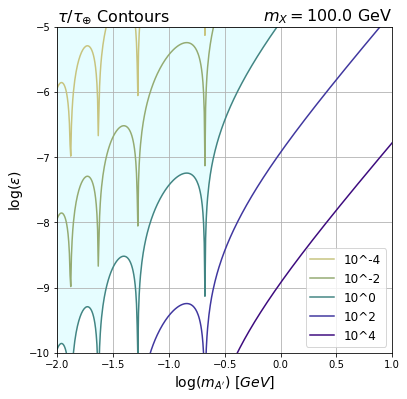

Complete


In [41]:
# Define custom Color scheme
colorScheme1 = mpl.cycler(color=['#c7c47e','#94ab72','#428583','#40379f','#3d0b7e']) 

fig1 = plt.figure(figsize = (6,6))

sommParam = int(input('Sommerfeld on? No:0 Yes:1 '))
assert ((sommParam == 0) or (sommParam == 1)), 'Invalid Input, must be 0 or 1.'


########################################
# This uses a custom color scheme defined in Masterfunctions_Graphing
########################################
colors = colorScheme1
mpl.rcParams['axes.prop_cycle'] = colors

########################################
# Produce the contour lines
########################################
testFill = False
for key in contourDictionary:
    if (float(key) == 0):
        testFill = True
    assert (len(maRange) == len(contourDictionary[key][sommParam])), 'ContourDictionary is probably not populated'
    plt.plot(np.log10(maRange), (contourDictionary[key][sommParam]), label = r'10^{0}'.format(key))
    

########################################  
# Shade the valid region of parameter space   
########################################
if (testFill == True):
    xs = np.log10(maArray)
    y1 = contourDictionary['0'][sommParam]
    plt.fill_between(xs, y1, -5, color = '#E6FDFF')

########################################
# Define plot label stuff
########################################
plt.legend(loc = 'lower right', fontsize = 12)
plt.xlabel(r"$\log(m_{A'})$ $[GeV]$", fontsize = 14)
plt.ylabel(r'$\log(\varepsilon)$', fontsize = 14)

plt.title(r'$m_X = {0}$ {1}'.format(m_XDisplay, m_XUnit),\
          fontsize = 16,\
          loc = 'right')

plt.title(r'$\tau/\tau_{\oplus}$ Contours',\
          fontsize = 16,\
          loc = 'left')
plt.axis([np.log10(min(maRange)),np.log10(max(maRange)),-10,-5])
plt.grid()
plt.show()

print ('Complete')

### Save Figure

In [15]:
filename = input('Figure Name: ')
assert (filename != ''), 'No Filename'
fig1.savefig(filename, dpi = 700)

print ('Complete')

Figure Name: testEqPlot.png
Complete


# IceCube Signal

### Recipie

The recipie for generating the Signal File is:

1. Read in a Sommerfeld csv and branching ratio csv

2. Define the resolution of the signal plot

3. Check this resolution
 
4. Initialize a template dataframe to hold the signal rate calculations

5. Write that dataframe to an external csv file

6. **This step is time consuming and computationally intensive.** <BR> Loop through signalData.csv, calculate $C_{Cap}$, $C_{Ann}$, $\Gamma_{Ann}$, and $N_{Sig}$, append them to signalData.csv

Step six can be quite lengthy depending on the desired resolution of the data points. Typically, one would begin these calculations and be forced to wait until they are completed in their entirety; perhaps unable to shut down their machine for hours at a time. The cell "Signal File Calculations" however can be interrupted at any time, and resumed later. This allows the user to run the calculation in multiple stages instead of dedicating a large chunk of time and running the calculation all at once. 
The calculation can be stopped by interrupting the Jupyter Kernel. Be sure to run the "Manual Overwrite" cell just to be sure that the calculations are saved.

## Initialize Signal.csv

### Read in External Files

In this cell, the user will read in two files:

1. A completed Sommerfeld csv
2. A csv containing the branching ratio for a given process

We have provided the file `brtoe.csv` for the process $A' \rightarrow e^+e^-$ as a sample.
From these files, we generate interpolations for use in caluculating the signal rate.

In [14]:
SommFileName = input('Sommerfeld File: ')

branchFileName = (input('Branching File: '))

print ('Complete')

Sommerfeld File: 100GeVSommerfeld.csv
Branching File: brtoe.csv
Complete


### Define the Resolution of the Signal Plot

This cell initializes the resolution of the signal plot and consequently, the sampling density for the Sommerfeld enhancement. The variable `num` defines the resolution of this grid, so if `num = 50`, the reach plot will have a $50 \times 50$ resolution and the Sommerfeld interpolation will contain 50 data points. Clearly, the number of calculatons for the reach plot is $\texttt{num}^2$. We compare the resolution of the signal plot to the sommerfeld enhancement because the Sommerfeld effects are very sensitive to $m_{A'}$. In other words, small variations in $m_{A'}$ can drastically affect the Sommerfeld enhancement. If the reslution it too low, these drastic effects will not be captured, and the Sommerfeld effect will no longer be accurate. 

For the provided Sommerfeld file, `100GeVSommerfeld.csv`, the suggested resolution is `num = 200`. As `m_x` increases though, `num` will also need to increase to capture the finer and finer details of the Sommerfeld enhancement.

One way understand what `num` does: "The smoother the Sommerfeld interpolation, the smoother the reach plots will be." If `num` is too small, the Sommerfeld interpolation will be jagged, and the resulting reach plots will also contain these jagged features. Making `num` larger will smooth out the interpolation and smooth out the reach plots, but it will take longer to calculate. 

To demonstrate this point, read in `100GeVSommerfeld.csv` in the cell above and compare the Sommerfeld plots with `num = 40` to `num = 200'.

In [4]:
num = 40

print ('Complete')

Complete


### External File Interpolations

The following cells read in and create interpolations of the:

1). Sommerfeld Enhancement

2). Branching ratio


The file names for both these files will be written to the $\texttt{signalData.csv}$ file. The reasoning behind this is to aid with the continuity of the calculation. If you want to run this notebook from top to bottom, you can calculate everything in one go. However, if you interrup the main calculation cell and restart your computer, all of the vairables loaded into Jupyter memory get wiped and the calculation will start from the very beginning. Writing these file names into the signalData.csv file means that to resume the calculation, you only need to run the main calculation cell as opposed to loading variables into Jupyter memory before starting the main calculation.

#### Sommerfeld Data Interpolation

In this cell, we generate two plots of the Sommerfeld enhancement which will help to inform an appropriate value for `num`. 

The left plot is generated with a sampling of `num` points, representing the resolution of the final signal plot. The right plot is generated using all points from the Sommerfeld file as defined in the `Sommerfeld` section of this notebook. The idea is that the resolution of the left plot will also be the resolution of the final signal plot. If the plot with `num` points is jagged and rough, the final signal plot will also be jagged and rough. Therefore, the parameter `num` should be tuned, by changing it and rerunning this cell, to capture an appropriate resolution of the Sommerfeld enhancement. However, the larger `num` is, the longer the signal calculation will take since these calculations scale as `num`$^2$. Ultimately, the tradeoff is resolution and computation time.

Complete


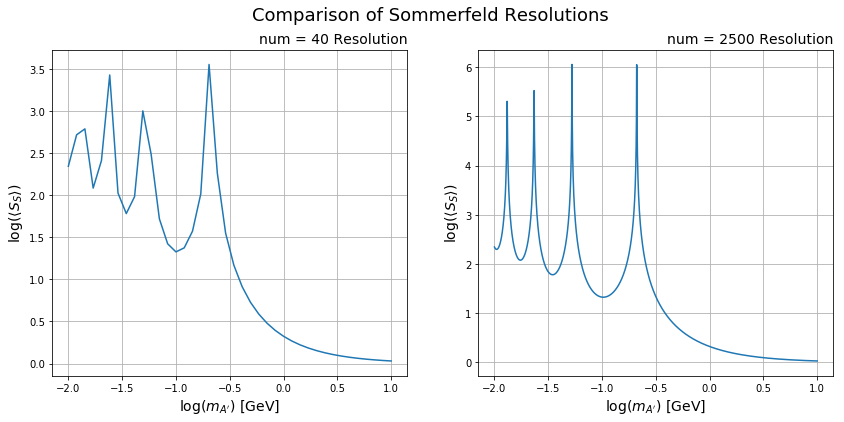

In [5]:
SommFile = pd.read_csv(sommerfeldPath(SommFileName))

####################################
# Interpolate Sommerfeld data
####################################
mAData = SommFile['mA[GeV]']
SommData = SommFile['ThermAvgSommerfeld']
SommInterp = interpolate.interp1d(mAData,SommData)

####################################
# Create Comparison Plots
####################################
m_XSommerfeld = SommFile.loc[0,'mX[GeV]']
kappa0Sommerfeld = SommFile.loc[0,'Kappa0[GeV5]']


vect1 = [] # To store m_A values
vect2 = [] # To store Sommerfeld values
for ma in np.logspace(np.log10(min(mAData)),np.log10(max(mAData)), num, base = 10):
    vect1.append(ma)
    vect2.append(SommInterp(ma))
        
        

fig1 = plt.figure(figsize = (14,6))
plt.suptitle('Comparison of Sommerfeld Resolutions', fontsize = 18)

ax1 = fig1.add_subplot(1,2,1)
ax1.plot(np.log10(vect1),np.log10(vect2),color = '#1f77b4')
ax1.set_xlabel(r"$\log(m_{A'})$ [GeV]", fontsize = 14)
ax1.set_ylabel(r"$\log(\langle S_S \rangle)$", fontsize = 14)
ax1.set_title('num = {0} Resolution'.format(num), fontsize = 14, loc = 'right')
plt.grid()

ax2 = fig1.add_subplot(1,2,2)
ax2.plot(np.log10(mAData), np.log10(SommData), color = '#1f77b4')
ax2.set_xlabel(r"$\log(m_{A'})$ [GeV]", fontsize = 14)
ax2.set_ylabel(r"$\log(\langle S_S \rangle)$", fontsize = 14)
ax2.set_title('num = 2500 Resolution', fontsize = 14, loc = 'right')
plt.grid()


print ('Complete')

#### Branching Ratio Interpolation

In this cell, we read in a .csv file containing discrete branching ratio data points obtained from WebPlotDigitizer and interpolate them into a continuous funciton named `branchRatioInterp`.

The interpolation of this file is indeendent of the resolution chosen for `num` above. Hence, the resolution for this interpolation is fixed by the number of data points given in the branching ratio .csv file. For the process $A' \rightarrow e^+ e^-$, there are 176 data points, so the interpolation uses all 176 points. 

Complete


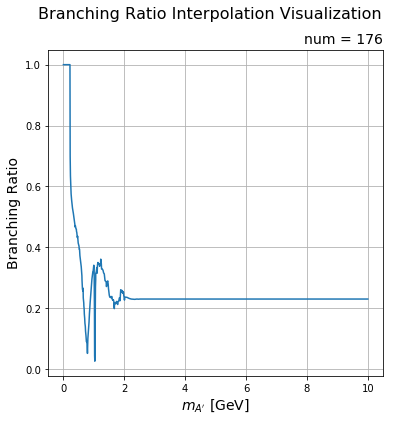

In [15]:
branchFile = pd.read_csv(branchPath(branchFileName))

xListBranch = branchFile['mA[GeV]']
yListBranch = branchFile['BR']

branchRatioInterp = interpolate.interp1d(xListBranch,yListBranch)

fig = plt.figure(figsize = (6,6))
plt.plot(xListBranch,yListBranch)
plt.xlabel(r"$m_{A'}$ [GeV]", fontsize = 14)
plt.ylabel(r"Branching Ratio", fontsize = 14)
plt.suptitle('Branching Ratio Interpolation Visualization', fontsize = 16)
plt.title('num = {0}'.format(len(xListBranch)), fontsize = 14, loc = 'right')
plt.grid()


print ('Complete')

### Initialize Signal Dataframe

This cell:

1. Initializes the signal data frame

2. Appends the $\varepsilon$ and $m_{A'}$ data points based on the resolution dictated by the variable `num`. By default, the range for mediator mass and kinetic mixing are dictated by the range of $m_{A'}$ in the Sommerfld file, and $10^{-11} \leq \varepsilon \leq 10^{-5}$. To change the range of $\varepsilon$, adjust the arguments of the variable `epsilonLogRange`.

3. Appends the column headers to the data frame

Here, we provide a description of the purpose of each column. If the column values have units, we have included units in square brackets in the column headers.

- `counter`: Explicitly stores the current row of the file. This is used as a loop variable to resume the calculation should it be stopped.
- `mX[GeV]`: Stores the value of $m_X$ taken directly from the Sommerfeld csv

- `mA[GeV]`: Stores `num` values of $m_A$ in the range $0.01 \ \text{GeV} \leq m_{A'} \leq 10 \ \text{GeV}$

- `Epsilon`: Stores `num` values of $\varepsilon$ in the range $10^{-11} \leq \varepsilon \leq 10^{-5}$

- `Capture[s-1]`: Stores the value of $C_\text{cap}$ for the values in the corresponding row

- `Annihilation[s-1]`: Stores the value of $C_\text{ann}$ for the values in the corresponding row

- `GammaAnn[s-1]`:Stores the value of $\Gamma_\text{ann}$ for the values in the corresponding row

- `IceCubeSignal`: Stores the value of $N_{sig}$ for the values in the corresponding row

- `LiveTime[s]`: Stores the live time of the experiment in seconds. By default, this is 10 years.

- `SommerfeldFile`: Stores the name of the working Sommerfeld file

- `BranchingRatioFile`: Stores the name of the working branching ratio file

- `Resolution`: Stores the value for the parameter `num`

- `Kappa0[GeV5]`: Stores the value of $\kappa_0$ taken directly from the Sommerfeld csv

In [19]:
#########################################
# Define parameter space Ranges
#########################################
# Logarithmic Spacing because we plot this in log-log space
# 0.01 GeV < mA < 10 GeV
# 10^-11 < Epsilon < 10^-5

maMin = (min(mAData))
maMax = (max(mAData))

mALogRange = np.logspace(np.log10(maMin), np.log10(maMax), num, base = 10)
epsilonLogRange = np.logspace(-11, -5, num, base = 10)

#########################################
# Initialize Master Arrays
#########################################
masterSignalArray = []

#########################################
# Populate the Master Arrays with the column headers and 'None' Cells
#########################################
counter = 0
for mATemp in mALogRange:
    for epsilonTemp in epsilonLogRange:
        masterSignalArray.append([counter, ' ', mATemp, epsilonTemp, \
                                  'None', 'None', 'None', 'None', ' ', \
                                  ' ', ' ',' ', ' '])
        counter +=1
#########################################
# Create a PANDAS DataFrame from the Master Arrays
#########################################
masterSignalDataframe = pd.DataFrame(data = masterSignalArray, \
    columns=['Counter', 'mX[GeV]', 'mA[GeV]', 'Epsilon',\
             'Capture[s-1]', 'Annihilation[s-1]', 'GammaAnn[s-1]', 'IceCubeSignal', 'LiveTime[s]', \
             'SommerfeldFile', 'BranchingRatioFile','Resolution','Kappa0[GeV5]'])

print ('Complete')

Complete


### Write to External .csv File

This cell writes the signal data frame to an external csv file. The naming convention should follow the Sommerfeld csv file, namely:
    
    <#><unit>Signal.csv

So for $m_X = 100$ GeV, the corresponding signal file would be named:

    100GeVSignal.csv

We also print out all values to bed written to this csv just to double check they are all correct. These values uniquely determine a calculation.

In [20]:
signalFileName = input('Signal Rate filename: ')
if signalFileName == '':
    print ("Using default filename")
    sinalFileName = 'Signal_DEFAULT.csv'
signalFile = signalPath(signalFileName)
assert (signalFileName[-4:] == '.csv'), 'Must inclue ".csv" in the file name'

#############################
# Double check that these values are correct
#############################
liveTime = DarkCapPy.Configure.Conversions.yr2s(10)

print ('--------------------')
print ('You are about to write the following to {0}'.format(signalFileName))
print ('mX[GeV]             : {0}'.format(m_XSommerfeld))
print ('Kappa0[GeV5]        : {0}'.format(kappa0Sommerfeld))
print ('Live Time           : {0}'.format(liveTime))
print ('Sommerfeld File     : {0}'.format(SommFileName))
print ('Branching Ratio File: {0}'.format(branchFileName))
print ('Resolution          : {0}'.format(num))
print ()

yesNo = input ('Write to {0}.csv? (y/n) '.format(signalFileName))
assert (yesNo == 'y' or yesNo == 'n'), 'Invalid input, must be "y" or "n."'

if ((yesNo == 'y') or (yesNo == 'Y')):
    kappa0Value = 'None'
    m_XValue = 'None'
    
    masterSignalDataframe.at[0, 'mX[GeV]']            = m_XSommerfeld
    masterSignalDataframe.at[0, 'Kappa0[GeV5]']       = kappa0Sommerfeld
    masterSignalDataframe.at[0, 'LiveTime[s]']        = liveTime
    masterSignalDataframe.at[0, 'SommerfeldFile']     = SommFileName
    masterSignalDataframe.at[0, 'BranchingRatioFile'] = branchFile
    masterSignalDataframe.at[0, 'Resolution']         = num

    masterSignalDataframe.to_csv(signalFile, index=False)
    
    print ('Write executed')
    
else:
    print ('Write aborted')

print ('Complete')

Signal Rate filename: testSignal2.csv
--------------------
You are about to write the following to testSignal2.csv
mX[GeV]             : 100.0
Kappa0[GeV5]        : 5.851659530104901e+27
Live Time           : 315360000.0
Sommerfeld File     : 100GeVSommerfeld.csv
Branching Ratio File: brtoe.csv
Resolution          : 40

Write to testSignal2.csv.csv? (y/n) y
Write executed
Complete


----------------------

Run these two cells onces you have a working signalData.csv file and you want to either start or resume calculations.

## Signal.csv Calculations

** This cell is the main work-horse of this notebook**

This is the cell where the signal csv file is populated with values. 

The algorithm is:
1. Input an incomplete signal file
2. Create a backup of that file. This ensures that even if the calculation is interrupted and the manual overwrite isn't run, that not all data will be lost.
3. Generate interpolations of the Sommerfeld effects and branching ratio
4. Iterate through the `counter` column looking at the value of `IceCubeSignal`
    4. If `IceCubeSignal` is `None`, compute all values in that row
    4. Else, continue to loop
5. Append newly calculated values to the csv
6. Overwrite the csv
7. Loop steps 2-6.


Since this is the main working cell in this notebook, there are a number of features intended to make the users life easier. First, once the user has generated a signal file, this is the only cell needed to perform calculations and populate a signal file. Said another way, there are no other cells to load variables into Jupyter memory other than the inialization cells. Second, depending on the resolution of your plot, this calculation may take $\mathcal{O}(10)$ hours to complete. Since this cell saves each iteration to an external file, we have intended this calcuation to be interrupted, by interrupting the Jupyter kernel, and resumed later. There is a subtlety in doing this though. Durring the debugging stage, occassionally after interrupting the Kernel, the external csv would be completely blank. To prevent this, it is imparitive that the Manual Overwrite cell is run. This ensures that even if the kernel is interrupted in such a way that the external csv is blank, the dataframe stored in Jupyter memory is still written to the csv and no data is lost. Failure to run the manual overwrite cell may result in a loss of the entire signal file.

To resume this calculation, simply run this cell and input the file to continue caluclating. The algorithm will iterate through the `counter` column until it finds a row which hasn't been calculated.

As a benchmark, with a resolution of `num = 200`, the upper left plot of Fig. 3 in [https://arxiv.org/abs/1509.07525](https://arxiv.org/abs/1509.07525) took about 8 hours of run time.


In [16]:
#########################################
# Read in Signal File
#########################################
signalFileName = input('Signal Rate File: ')
signalFile = signalPath(signalFileName)
signalDataIn = pd.read_csv(signalFile, sep = ',')

#########################################
# Create backup of Signal File 
#########################################
now = datetime.now()
timeStamp = now.strftime('%b-%d_%H.%M')
signalFileNameCopy = signalFileName[:-4] + '_' + timeStamp + '.csv'
signalDataIn.to_csv(signalBackupPath(signalFileNameCopy), sep=',', index=False)
print ('Backup Created')


#########################################
# Constants in (mA, epsilon) space:
#########################################
signalm_X = float(signalDataIn.at[0, 'mX[GeV]'])
FileKappa0 = float(signalDataIn.at[0, 'Kappa0[GeV5]'])
Alpha = 1./137
LiveTime = signalDataIn.at[0, 'LiveTime[s]']


#########################################
# Sommerfeld Interpolation
#########################################
sommFileName = signalDataIn.at[0,'SommerfeldFile']
sommDataIn = pd.read_csv(sommerfeldPath(sommFileName))
mAData = sommDataIn['mA[GeV]']
SommDataValues = sommDataIn['ThermAvgSommerfeld']
SommInterp = interpolate.interp1d(mAData,SommDataValues)

#########################################
# Branching Ratio Interpolation
#########################################
branchFileName = signalDataIn.at[0,'BranchingRatioFile']
branchDataIn = pd.read_csv(branchPath(branchFileName))
mABranch = branchDataIn['mA[GeV]']
branchingDataValues = branchDataIn['BR']
branchRatioInterp = interpolate.interp1d(mABranch,branchingDataValues)


#########################################
# Begin iterating through the file
#########################################
loopRange = range(0,len(signalDataIn['Counter']))
print ()
print ('--------------------')
finishedCounter = 0
index = 0
for index in loopRange:
    testValue = signalDataIn.loc[index, 'IceCubeSignal']
    
    if (testValue == 'None'):
        #########################################
        # Initialize iteration-specific Quantities
        #########################################
        signalm_ATemp = float(signalDataIn.at[index, 'mA[GeV]'])
        FileEpsilonTemp = float(signalDataIn.at[index, 'Epsilon'])
        Alpha_X = DP.alphaTherm(signalm_X, signalm_ATemp)      
        Sommerfeld = SommInterp(signalm_ATemp)
        BranchingRatio = branchRatioInterp(signalm_ATemp)
        
        #########################################
        # Parameter Spce Calculations
        #########################################
        Capture = DP.cCapQuick(signalm_X, signalm_ATemp, FileEpsilonTemp, Alpha_X, FileKappa0)
        SigmaVTree = DP.sigmaVtree(signalm_X, signalm_ATemp, Alpha_X)
        Annihilation = DP.cAnn(signalm_X, SigmaVTree, thermAvgSomm = Sommerfeld)
        GammaAnn = DP.gammaAnn(Capture, Annihilation)
        L = DP.decayLength(signalm_X, signalm_ATemp, FileEpsilonTemp, BranchingRatio)
        EpsilonDecay = DP.epsilonDecay(L)
        
        IceCubeSignal = DP.iceCubeSignal(GammaAnn, EpsilonDecay, LiveTime)

        #########################################
        # Append Calculated Values to SignalFile.csv
        #########################################
        signalDataIn.at[index, 'Capture[s-1]']      = Capture
        signalDataIn.at[index, 'Annihilation[s-1]'] = Annihilation
        signalDataIn.at[index, 'GammaAnn[s-1]']     = GammaAnn
        signalDataIn.at[index, 'IceCubeSignal']     = IceCubeSignal
        
        
        #########################################
        # Overwrite SignalFile.csv
        #########################################
        signalDataIn.to_csv(signalFile, sep=',',index=False) 
        finishedCounter += 1
        
        if (index % 20 == 0):
            print ('Calculations for index: {0} recorded'.format(index))
        
    elif (testValue != 'None'):
        finishedCounter += 1
    
    if (finishedCounter == len(signalDataIn['Counter'])):
        print ('--------------------')
        print ('All Calculations Complete')
        break
        
print ('Complete')

Signal Rate File: testSignal.csv
Backup Created

--------------------
Calculations for index: 0 recorded
Calculations for index: 20 recorded
Calculations for index: 40 recorded
Calculations for index: 60 recorded


KeyboardInterrupt: 

### Manual Overwrite

This cell is a manual overwrite of the signalData.csv file.

It is REQUIRED that you run this if you interrupt the calculation. Failure to do so could result in a loss of all your data.

In [17]:
print ('Working Signal File: {0}'.format(signalFile))

overwrite = input('Overwrite? (y/n): ')
if ((overwrite == 'y') or (overwrite == 'Y')):
    signalDataIn.to_csv(signalFile, sep=',',index=False) 
    print ('Overwrite complete')
    
else:
    print ('Overwrite aborted')

print ('Complete')

Working Signal File: Signal/testSignal.csv
Overwrite? (y/n): y
Overwrite complete
Complete


## Plot Signal Events

### Extract Plot Data

This cell reads in a completed signal file and plots `mA[GeV]` on the horizontal axis, `Epsilon` on the vertical axis, and `IceCubeSignal` as contours.

In [45]:
signalFile = input('Signal Rate filename: ')
readFile = signalPath(signalFile)
rawData = pd.read_csv(readFile)
Filem_X = float(rawData.loc[0,'mX[GeV]'])

#Pull out min / max values on each axis
xMin = min(rawData['mA[GeV]'])
xMax = max(rawData['mA[GeV]'])
yMin = min(rawData['Epsilon'])
yMax = max(rawData['Epsilon'])


#########################################
# Define the dimension of the grid. 
# For an n x n grid, this will pull out the number "n"
#########################################
gridDim = int(rawData.loc[0,'Resolution'])


#########################################
# Create the n x n grid
#########################################
# Logarithmic Spacing
xLogRange = np.logspace(np.log10(xMin), np.log10(xMax) , gridDim, base = 10)
yLogRange = np.logspace(np.log10(yMin), np.log10(yMax), gridDim, base = 10)


#########################################
# Read in and reshape the Contour data
#########################################
# This reads in contour data as a single column,
#     but we reshape it to a 2D, n x n array to fit the grid

z = [rawData['IceCubeSignal']]
SignalData = np.reshape(z, (len(xLogRange), len(yLogRange)))

print ('Complete')

Complete


### Plot the Signal Events

C:\Users\Adam Green\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


Complete


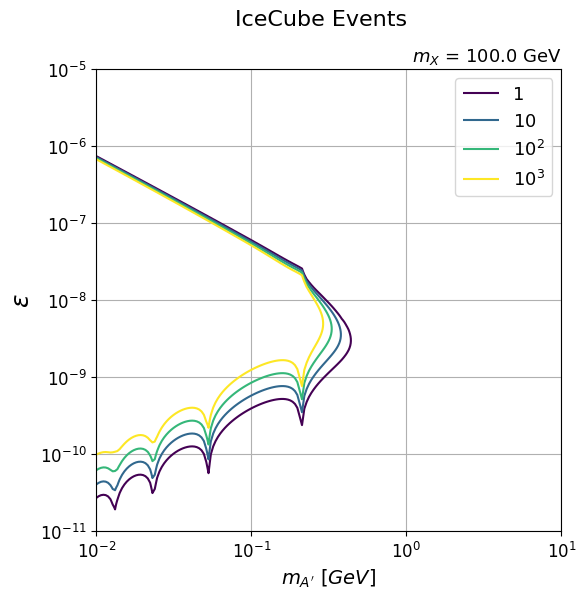

In [48]:
###############################
# Set the correct units for m_X
###############################
m_XUnit = 'None'
if (Filem_X < 1000):
    m_XDisplay = Filem_X
    m_XUnit = 'GeV'

if (Filem_X >= 1000):
    m_XDisplay = Filem_X * 10**-3
    m_XUnit = 'TeV'
    
    
###############################
# Plotting
###############################
signalFig = plt.figure(figsize = (6,6))

CP = plt.contour(np.log10(xLogRange), np.log10(yLogRange), \
                 np.log10(SignalData.transpose()),\
                 levels=[0,1,2,3],\
                )

xLabelNums = [-2,-1,0,1]
xLabelText = [r'$10^{-2}$',r'$10^{-1}$',r'$10^{0}$',r'$10^{1}$']

yLabelNums = [-5,-6,-7,-8,-9,-10,-11]
yLabelText = [r'$10^{-5}$', r'$10^{-6}$', r'$10^{-7}$', r'$10^{-8}$', \
              r'$10^{-9}$', r'$10^{-10}$', r'$10^{-11}$']


plt.xticks(xLabelNums, xLabelText, fontsize = 12)
plt.yticks(yLabelNums, yLabelText, fontsize = 12)

plt.xlabel(r"$m_{A'}$ $[GeV]$", fontsize = 14)
plt.ylabel(r'$\varepsilon$', fontsize = 18)
plt.suptitle('IceCube Events', fontsize = 16)
plt.title(r'$m_X$ = {0} {1}'.format(m_XDisplay, m_XUnit), loc = 'right', fontsize = 13)

labels = [r'1', r'$10$',r'$10^2$',r'$10^3$']
for i in range(len(labels)):
    CP.collections[i].set_label(labels[i])

plt.legend(loc='upper right', fontsize = 13)
plt.grid()
print ('Complete')

#### Save Figure

In [51]:
figName = input('Filename: ')

signalFig.savefig((figName), dpi = 700,
             bbox_inches = 'tight', # If this isn't here, it partially cuts off the axis labels
            )
print ('Complete')

Filename: testSignal2.png
Complete
